# Building a CLIP Inspired Multi-Modal Model

Submitted by: Rishabh Kaushick

# 1. Environment Setup (5%)

In [ ]:
%pip install --quiet torch torchvision transformers datasets matplotlib tqdm pillow

In [2]:
%reset

## Importing Libraries

In [1]:
from datasets import load_dataset, load_from_disk

import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests

from transformers import CLIPTokenizer, DistilBertTokenizer, DistilBertModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

/opt/homebrew/anaconda3/envs/csye7230/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting up GPU

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
 
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
        print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")
 
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.6.0
Is CUDA available: False
CUDA is not available. Running on CPU.


# 2. Dataset Selection and Exploration (10%)

For this assignment, I have decided to use the Flickr30k dataset. The reasons for this are as follows:
1.	The Flickr30k dataset contains much lesser images as compared to the COCO dataset. This will be easier to train due to the GPU limitations.
2.	The Flickr30k dataset contains high quality natural language captions. The COCO dataset has complex captions which could introduce more variability making the training process more difficult.
3.	Flickr30k dataset is suited for retrieval-based tasks.


## Save & Load Dataset

In [ ]:
# Load the Flickr30k dataset from Hugging Face
dataset = load_dataset("nlphuji/flickr30k", split="test[:10000]")

# looks like the main train split is called test

I have considered the first 10k records so that it is easier to train the data with limited time and resources.

In [ ]:
print(dataset)

### Save Dataset to Disk

In [ ]:
# need to save the dataset in /data/flickr10k
dataset.save_to_disk("./data/flickr10k")

### Load Dataset from Disk

In [3]:
dataset = load_from_disk("./data/flickr10k")

In [4]:
dataset

Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 10000
})

In [5]:
dataset.info

DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(mode=None, decode=True, id=None), 'caption': [Value(dtype='string', id=None)], 'sentids': [Value(dtype='string', id=None)], 'split': Value(dtype='string', id=None), 'img_id': Value(dtype='string', id=None), 'filename': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='flickr30k', config_name='TEST', version=1.1.0, splits={'test': SplitInfo(name='test', num_bytes=4326502343, num_examples=31014, shard_lengths=[3800, 3700, 3700, 3800, 3600, 3400, 3300, 3600, 2114], dataset_name='flickr30k')}, download_checksums={'hf://datasets/nlphuji/flickr30k@cd91f9a00273ce2e1584511cba8c10b917c488a3/TEST/test/0000.parquet': {'num_bytes': 505667437, 'checksum': None}, 'hf://datasets/nlphuji/flickr30k@cd91f9a00273ce2e1584511cba8c10b917c488a3/TEST/test/0001.parquet': {'num_bytes': 501896374, 'checksum': None}, 'hf://datasets/nlphuji/flickr30k@cd91f9a0027

In [6]:
dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'caption': [Value(dtype='string', id=None)],
 'sentids': [Value(dtype='string', id=None)],
 'split': Value(dtype='string', id=None),
 'img_id': Value(dtype='string', id=None),
 'filename': Value(dtype='string', id=None)}

In [7]:
dataset_df = dataset.to_pandas()

In [8]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     10000 non-null  object
 1   caption   10000 non-null  object
 2   sentids   10000 non-null  object
 3   split     10000 non-null  object
 4   img_id    10000 non-null  object
 5   filename  10000 non-null  object
dtypes: object(6)
memory usage: 468.9+ KB


### Split (Train, Val, Test)

In [9]:
dataset_df['split'][0:10]

0    train
1    train
2    train
3    train
4    train
5    train
6    train
7    train
8    train
9    train
Name: split, dtype: object

Checking if we have all three in the 10k subset of the dataset.

In [10]:
split_value_counts = dataset_df['split'].value_counts()
split_value_counts

split
train    9375
test      324
val       301
Name: count, dtype: int64

Looks like we have all 3 as shown above. Now let's check how many of each set is present in the 10k records.

In [11]:
print(f"Training Set Count: {split_value_counts['train']} ({(split_value_counts['train']/10000)*100:.2f}%)")
print(f"Validation Set Count: {split_value_counts['val']} ({(split_value_counts['val']/10000)*100:.2f}%)")
print(f"Testing Set Count: {split_value_counts['test']} ({(split_value_counts['test']/10000)*100:.2f}%)")

Training Set Count: 9375 (93.75%)
Validation Set Count: 301 (3.01%)
Testing Set Count: 324 (3.24%)


We can see that the train set is more than 90%, and the test and validation sets are much smaller in comparison. 

In this project, I will use a custom train-val-test split:
- 80% training
- 10% validation 
- 10% test set

In [12]:
dataset = dataset.remove_columns('split')

In [13]:
# first creating 80% train, 20% test
train_test_data = dataset.train_test_split(test_size=0.2, seed=23)

# out of the 20% test taking half of it as train and test again for validation
val_test_data = train_test_data['test'].train_test_split(test_size=0.5, seed=23)

train_dataset = train_test_data['train']
val_dataset = val_test_data['train']
test_dataset = val_test_data['test']

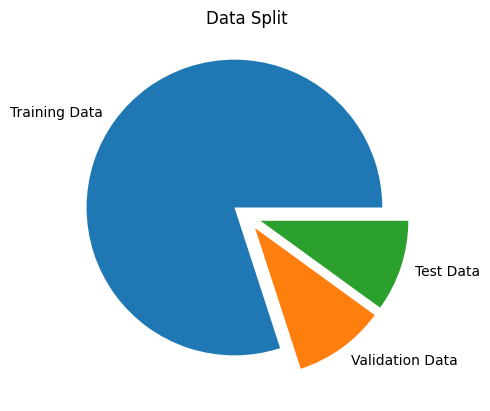

In [14]:
y = np.array([train_dataset.num_rows, val_dataset.num_rows, test_dataset.num_rows])
labels = ['Training Data', 'Validation Data', 'Test Data']
plt.pie(y, labels=labels, explode=[0.1,0.1,0.1])
plt.title("Data Split")
plt.show()

## Exploring the dataset

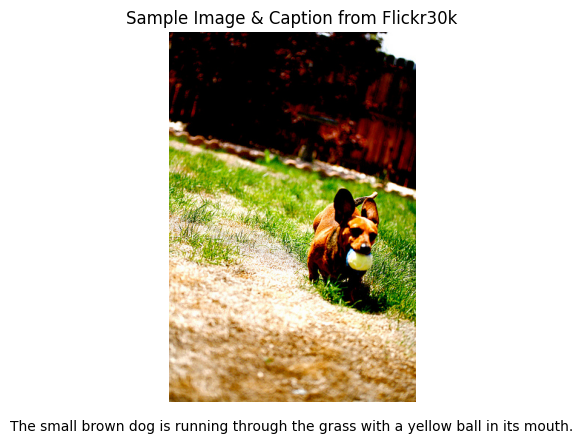

In [15]:
# Sample from the training set
sample = train_dataset[0]
image = sample["image"] 
caption = sample["caption"]

# Display Image
plt.imshow(image)
plt.axis("off")
plt.title('Sample Image & Caption from Flickr30k')
plt.text(0.5, -0.05, caption[0], ha='center', va='top', transform=plt.gca().transAxes)
plt.show()

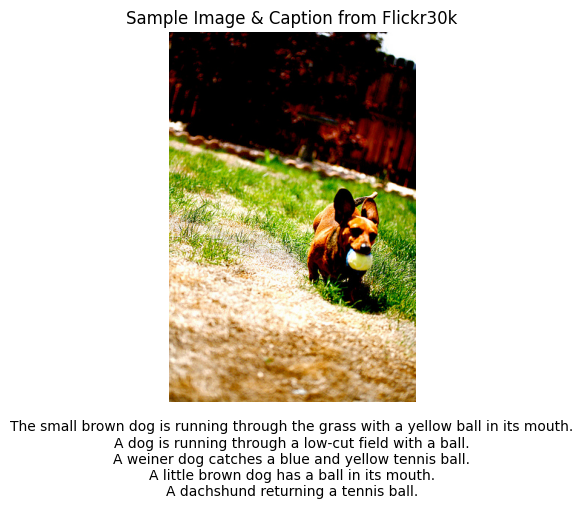

In [16]:
# Sample from the training set
sample = train_dataset[0]
image = sample["image"]
caption = sample["caption"]

# Display Image
plt.imshow(image)
plt.axis("off")
# Update to show all captions
plt.title('Sample Image & Caption from Flickr30k')
plt.text(0.5, -0.05, "\n".join(caption), ha='center', va='top', transform=plt.gca().transAxes)
plt.show()

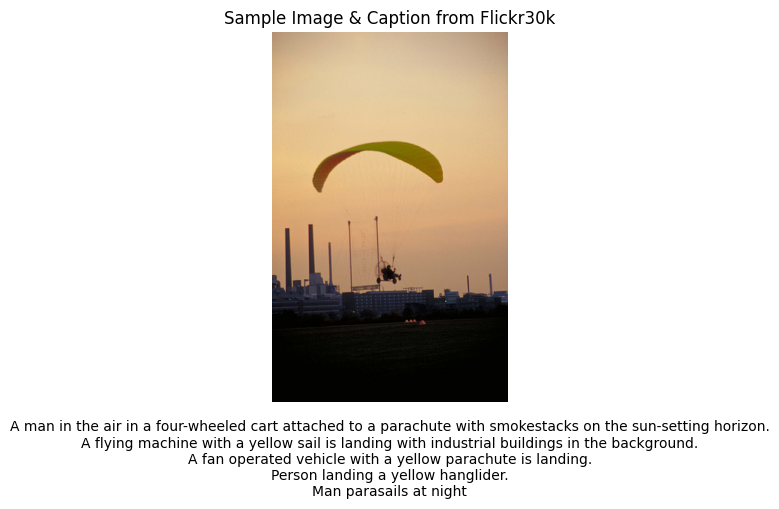

In [17]:
# Sample from the training set
sample = train_dataset[10]
image = sample["image"]
caption = sample["caption"]

# Display Image
plt.imshow(image)
plt.axis("off")
# Update to show all captions
plt.title('Sample Image & Caption from Flickr30k')
plt.text(0.5, -0.05, "\n".join(caption), ha='center', va='top', transform=plt.gca().transAxes)
plt.show()

### Dataset Characteristics

In [18]:
train_dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'caption': [Value(dtype='string', id=None)],
 'sentids': [Value(dtype='string', id=None)],
 'img_id': Value(dtype='string', id=None),
 'filename': Value(dtype='string', id=None)}

In [19]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 'caption': ['The small brown dog is running through the grass with a yellow ball in its mouth.',
  'A dog is running through a low-cut field with a ball.',
  'A weiner dog catches a blue and yellow tennis ball.',
  'A little brown dog has a ball in its mouth.',
  'A dachshund returning a tennis ball.'],
 'sentids': ['42790', '42791', '42792', '42793', '42794'],
 'img_id': '8558',
 'filename': '2800934095.jpg'}

We can see from the above that for our training process, we will only require the image and the captions.

### Preprocess Images

#### Resizing Images

In [20]:
image_data = train_dataset[0]['image']
image_width, image_height = image_data.size
print(f"Width: {image_width}, Height: {image_height}")

Width: 333, Height: 500


In [21]:
image_data = train_dataset[1020]['image']
image_width, image_height = image_data.size
print(f"Width: {image_width}, Height: {image_height}")

Width: 500, Height: 443


It appears as though each image has a different width and height, which is not favorable for the model. Let's first convert them all into a standard width and height of 128 x 128. 

Image before resizing


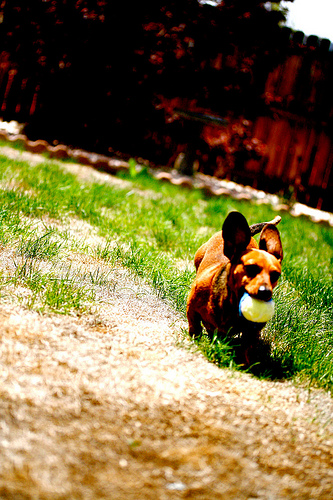

In [22]:
image_data = train_dataset[0]['image']
print("Image before resizing")
image_data


Image after resizing:


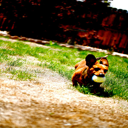

In [23]:
print("Image after resizing:")
image_data.resize((128, 128))

Now resizing all the images in the dataset:

In [24]:
def resize_image(example):
    example['image'] = example['image'].resize((128, 128))
    return example

In [25]:
# resizing the images in train and validation sets
resized_train_dataset = train_dataset.map(resize_image)
resized_val_dataset = val_dataset.map(resize_image)

In [26]:
resized_train_dataset

Dataset({
    features: ['image', 'caption', 'sentids', 'img_id', 'filename'],
    num_rows: 8000
})

In [27]:
resized_train_dataset['image'][:10]

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>]

From the above, we can see that all images have been resized.

#### Normalizing Pixel Values

In [28]:
min_value = np.min(resized_train_dataset['image'])
max_value = np.max(resized_train_dataset['image'])

In [29]:
print(f"Image pixel values range from {min_value} to {max_value}")

Image pixel values range from 0 to 255


Similarly performing normalization on all the image data.

In [30]:
def normalize_image(example):
    example['image'] = np.array(example['image'])/255.0
    return example

In [31]:
preprocessed_train_dataset = resized_train_dataset.map(normalize_image)
preprocessed_val_dataset = resized_val_dataset.map(normalize_image)

In [32]:
# this is taking too long to load
# resized_dataset['image'][:10]

In [33]:
preprocessed_train_dataset

Dataset({
    features: ['image', 'caption', 'sentids', 'img_id', 'filename'],
    num_rows: 8000
})

In [34]:
# this is taking too long to load
# resized_dataset['image'][0]

In [35]:
subset = preprocessed_train_dataset.select(range(10))  # Access the first 10 images

In [36]:
subset[0]['image']

[[[0.08627450980392157, 0.011764705882352941, 0.011764705882352941],
  [0.2823529411764706, 0.0392156862745098, 0.011764705882352941],
  [0.06666666666666667, 0.00784313725490196, 0.011764705882352941],
  [0.00784313725490196, 0.00392156862745098, 0.0],
  [0.0, 0.00392156862745098, 0.0],
  [0.0, 0.0, 0.00392156862745098],
  [0.0, 0.00392156862745098, 0.0],
  [0.0, 0.0, 0.0],
  [0.00392156862745098, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.00392156862745098, 0.0, 0.0],
  [0.011764705882352941, 0.00392156862745098, 0.00784313725490196],
  [0.09411764705882353, 0.03529411764705882, 0.027450980392156862],
  [0.13333333333333333, 0.07450980392156863, 0.06274509803921569],
  [0.09803921568627451, 0.011764705882352941, 0.011764705882352941],
  [0.054901960784313725, 0.0, 0.011764705882352941],
  [0.20392156862745098, 0.00784313725490196, 0.01568627450980392],
  [0.10588235294117647, 0.00784313725490196, 0.011764705882352941

From the above, we can see that the image now has values between 0 and 1 since we normalized it.

### Tokenize Captions
I've decided to use the DistilBERT tokenizer for the captions.

In [37]:
# tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Similarly creating a method to tokenize the entire captions column.

In [38]:
def tokenize_captions(example):
    example['tokenized_caption'] = tokenizer(example['caption'], padding="max_length", truncation=True)
    return example

In [39]:
preprocessed_train_dataset = preprocessed_train_dataset.map(tokenize_captions)
preprocessed_val_dataset = preprocessed_val_dataset.map(tokenize_captions)

Map: 100%|██████████| 1000/1000 [00:02<00:00, 443.27 examples/s]


In [40]:
subset = preprocessed_train_dataset.select(range(0,5))

In [41]:
subset[0]['tokenized_caption']

{'attention_mask': [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0

In [42]:
subset[0]['tokenized_caption'].keys()

dict_keys(['attention_mask', 'input_ids'])

When we tokenize the captions, the DistilBERT Tokenizer creates 'attention masks' and 'input ids' as we can see above.

# 3. Model Design (30%) 

![CLIP model design](./references/CLIP.png)

## Image Encoder

- The ResNet-18 model will be used as the backbone CNN model for feature extraction.
- The final layer of the ResNet18 will be removed
- A projection layer will be added at the end of the ResNet18 model to map data into a 512 dimension shared embedding space.

In [43]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super(ImageEncoder, self).__init__()
        # Load a pre-trained ResNet-18 model
        resnet = models.resnet18(pretrained=True)
        # Remove the final classification layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        # Add a projection layer to map to the joint embedding space
        self.projection = nn.Linear(512, embed_dim)
        # Normalization layer
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Extract features from the ResNet backbone
        features = self.backbone(x)
        # Flatten the features
        features = features.view(features.size(0), -1)
        # Project to embedding space
        embeddings = self.projection(features)
        # Normalize embeddings to have unit norm
        normalized_embeddings = self.norm(embeddings)
        return normalized_embeddings

## Text Encoder

- DistilBERT will be used as the backbone model for processing text.
- Most parameters except the last layer will be frozen to reduce training time. Since the DistilBERT architecture consists of 6 layers (0 to 5), we will freeze layers 0 to 4 and allow the layer 5 to updated 
during training.
- Will takes the [CLS] token embedding as the sentence representation.
- Will project this to the same 512-dimensional embedding space as the image encoder.

In [44]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super(TextEncoder, self).__init__()
        # Load pretrained DistilBERT model
        self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')     
        # Freeze most of the transformer layers (0 to 4) to reduce training time and prevent overfitting
        for name, param in self.transformer.named_parameters():
            if 'layer.5' not in name:  # DistilBERT has 6 layers (0-5), only train the last one (layer 5)
                param.requires_grad = False
        # DistilBERT outputs 768-dimensional features- so going from 768 to 512:
        self.projection = nn.Linear(768, embed_dim)
        # Normalization layer
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, input_ids, attention_mask):
        # Get the [CLS] token embedding from DistilBERT
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # Use the [CLS] token as the sentence representation
        # For DistilBERT, this is the first token of the last hidden state
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        # Project to the joint embedding space
        embeddings = self.projection(cls_embedding)
        # Normalize embeddings to have unit norm
        normalized_embeddings = self.norm(embeddings)
        return normalized_embeddings

## CLIP Model for Shared Embedding Space

- Combines both encoders into a single model.
- Includes a method to compute contrastive loss between image and text embeddings.
- Uses temperature scaling to control the sharpness of similarity distributions.

In [45]:
class CLIPModel(nn.Module):
    def __init__(self, embed_dim=512, temperature=0.07):
        super(CLIPModel, self).__init__()
        # Create the image encoder
        self.image_encoder = ImageEncoder(embed_dim=embed_dim)
        # Create the text encoder
        self.text_encoder = TextEncoder(embed_dim=embed_dim)
        # Temperature parameter for the loss calculation
        self.temperature = temperature
        self.embed_dim = embed_dim
        
    def forward(self, images, input_ids, attention_mask):
        # Encode images and text
        image_embeddings = self.image_encoder(images)  # Shape: [batch_size, embed_dim]
        input_ids = input_ids[:, 0, :]  # Shape: [batch_size, 77]
        attention_mask = attention_mask[:, 0, :]  # Shape: [batch_size, 77]

        text_embeddings = self.text_encoder(input_ids, attention_mask)  # Shape: [batch_size, embed_dim]
        # Normalize embeddings (optional if already done in individual encoders)
        image_embeddings = F.normalize(image_embeddings, p=2, dim=1)
        text_embeddings = F.normalize(text_embeddings, p=2, dim=1)
        return image_embeddings, text_embeddings
    
    def compute_contrastive_loss(self, image_embeddings, text_embeddings):
        # Compute cosine similarity matrix
        # Shape: [batch_size, batch_size]
        logits = torch.matmul(image_embeddings, text_embeddings.t()) / self.temperature
        # Create labels: diagonal elements should match (same index = positive pair)
        labels = torch.arange(logits.shape[0], device=logits.device)
        # Calculate loss for image-to-text direction
        image_loss = F.cross_entropy(logits, labels)
        # Calculate loss for text-to-image direction
        text_loss = F.cross_entropy(logits.t(), labels)
        # The total loss is the average of the two directional losses
        total_loss = (image_loss + text_loss) / 2
        return total_loss

# 4. Training Process (30%)

## Setting up the hyper-parameters

In [46]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# initialize hyper parameters
embed_dim = 512
batch_size = 64
num_epochs = 10
learning_rate = 1e-4

# tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Using device: cpu


## Creating Dataset 

While creating the dataset, we need to create a transforms pipeline to preprocess the data the same way we processed it above.

In [47]:
transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # normalizing vales are based on the standard normalization parameters from the original ResNet-18 documentation
    ])

### ImageTextDataset
This will be a custom Dataset that contains the images and the corresponding captions. 

In [54]:
class ImageTextDataset(Dataset):
    def __init__(self, images, captions, tokenizer, transform=None, max_length=77):
        self.images = images
        self.captions = captions
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load and transform image
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
            
        # Tokenize text
        caption = self.captions[idx]
        encoding = self.tokenizer(
            caption,
            return_tensors='pt',
            max_length=self.max_length, # the original CLIP paper uses max_length as 77
            # 77 tokens provides enough context to capture meaningful text descriptions while remaining computationally efficient
            padding=True,
            truncation=True
        )
        
        return {
            'image': image,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'caption': caption  # Keep original caption for reference
        }


The below code does all the preprocessing in one step and creates it as a ImageTextDataset:

In [49]:
train_dataset = ImageTextDataset(
    train_dataset['image'], 
    train_dataset['caption'], 
    tokenizer, 
    transform=transform
)

val_dataset = ImageTextDataset(
    val_dataset['image'], 
    val_dataset['caption'], 
    tokenizer, 
    transform=transform
)

Now the train_dataset & val_dataset have been processed and are objects of type 'ImageTextDataset'

In [50]:
type(train_dataset)

__main__.ImageTextDataset

## Creating DataLoaders

In [51]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
    
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## Training Loop

In [66]:
def train_clip_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, device='cuda'):
    # Move model to device
    model = model.to(device)
    
    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Learning rate scheduler (optional)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Training and validation metrics
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch in pbar:
            # Move data to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Zero gradients
            optimizer.zero_grad()

            input_ids = input_ids[:, 0, :]  # Shape: [64, 77]
            attention_mask = attention_mask[:, 0, :]  # Shape: [64, 77]

            # print("Input IDs shape:", input_ids.shape) # Input IDs shape: torch.Size([64, 77])
            # print("Attention mask shape:", attention_mask.shape) # Attention mask shape: torch.Size([64, 77])
            
            # Forward pass
            image_embeddings, text_embeddings = model(images, input_ids, attention_mask)
            
            # Compute loss
            loss = model.compute_contrastive_loss(image_embeddings, text_embeddings)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            train_batches += 1
            pbar.set_postfix({'loss': loss.item()})
        
        # Update learning rate
        scheduler.step()
        
        # Calculate average training loss for this epoch
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for batch in pbar:
                # Move data to device
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                
                # Forward pass
                image_embeddings, text_embeddings = model(images, input_ids, attention_mask)
                
                # Compute loss
                loss = model.compute_contrastive_loss(image_embeddings, text_embeddings)
                
                # Update metrics
                val_loss += loss.item()
                val_batches += 1
                pbar.set_postfix({'loss': loss.item()})
        
        # Calculate average validation loss for this epoch
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Save checkpoint (optional)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        }, f'clip_checkpoint_epoch_{epoch+1}.pt')
    
    # Return training history
    return train_losses, val_losses

## Start Training

In [ ]:
# Initialize model
model = CLIPModel(embed_dim=embed_dim)

# Train model
train_losses, val_losses = train_clip_model(
    model,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
    lr=learning_rate,
    device=device
)

Epoch 1/10 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]